In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import random
import time
import math
from utils import *

In [2]:

class Dense(torch.nn.Module):
    def __init__(self, n_in, n_out , sigmoid = False, pointwise = False):
        super(Dense, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        self.sigmoid = sigmoid
        self.pointwise = pointwise
        
        if not pointwise:
            self.weight = torch.zeros([n_in, n_out])
            self.reset_parameters()
        else:
            if n_in != n_out:
                raise Exception('n_in must be equal to n_out for pointwise operation, {} and {} where given'.format(n_in,n_out))
            self.weight = torch.zeros([n_in])
            self.reset_parameters()
            
    def sig(self,x):
        return 1 / (1 + torch.exp(-x))
    
    def sig_d(self, x):
        return x * (1 - x)

    def forward(self, a):
        if not self.pointwise:
            a = torch.matmul(a,self.weight).squeeze()
        else:
            a = self.weight * a
            
        if self.sigmoid:
            a = self.sig(a)
            
        return a

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(0))
        self.weight.data.uniform_(0.1, stdv)
        
    def weight_update(self, errors, lr = 0.01):
        pass
        


In [3]:
class Spike1d(torch.nn.Module):
    def __init__(self, n_in,n_out, thresh = 1, input_connections = [], mod = False, verbose = False):
        super(Spike1d, self).__init__()
        self.potentials = Parameter(torch.zeros(n_out, dtype=torch.float),requires_grad=False)
        self.thresh = thresh
        self.mod = mod
        self.n_out = n_out
        self.n_in = n_in
        self.verbose = verbose
        
        #Create list of timing errors and weights for each connected layer
        fc = []
        timings = []
        for idx,i in enumerate(n_in):
            is_input = (idx in input_connections)
            fc.append(Dense(i,n_out , pointwise  = is_input))
            if not is_input:
                timings.append(torch.zeros([n_out, i]))
            else:
                timings.append(torch.zeros([n_out, 1]))
                    
        self.timings = timings
        self.fc = fc
                
    def get_empty_spikes(self):
        return torch.zeros([self.n_out])
    
    def get_n_inputs(self):
        return len(self.n_in)
    
    def forward(self, in_spikes):
        #update potentials
        delta_p = torch.zeros([self.n_out])
        for idx,f in enumerate(self.fc):
            #only positive weights for now
            delta_p += (f(in_spikes[idx]))
            
        self.potentials = Parameter(self.potentials + delta_p)
        
        #generate spikes and uptade potentials accordingly
        spikes = (self.potentials >= self.thresh).float()
        if self.mod:
            #After spike overflow is kept
            self.potentials = Parameter(self.potentials - (spikes * self.thresh))
        else:
            #After spike potential is set to zero removing any overlow
            self.potentials = Parameter(self.potentials * (1 - spikes))

        #Calculate errors
        errors = []
        for idx,t in enumerate(self.timings):
            #Step timings
            t += 1 * torch.sign(t)
            
            #on in fire (Neurons want to fire sooner : weights are increased)
            if not self.fc[idx].pointwise: 
                t = t.transpose(0,1)
            
               
            positive_errors = []
            for i in range(t.shape[0]):
                if in_spikes[idx][i] == 1:
                    if self.verbose:
                        print("spike received from {} side {}".format(i,idx))
                      #  print(t[i])
                       # print("###")

                    positive_errors.append(t[i] * (t[i] < 0))
                    t[i][t[i] >= 0] += 1
                    t[i][t[i] < 0] = 0
                else:
                    positive_errors.append(torch.zeros(t[i].shape,dtype = torch.float))
            positive_errors = torch.stack(positive_errors,-1)
            
            if not self.fc[idx].pointwise:    
                t = t.transpose(0,1)
                positive_errors = positive_errors.transpose(0,1)
                
            errors.append(positive_errors)
            
            
            
            #on out fire (Neurons want to fire later : weights are decreased)
            negative_errors = []
            for i in range(t.shape[0]):
                if(spikes[i] == 1):
                    if self.verbose:
                        print("spike sent at {}".format(i))
                        #print(t[i])
                        #print("###")
                    negative_errors.append(t[i] * (t[i] > 0))
                    t[i][t[i] <= 0] -= 1
                    t[i][t[i] > 0] = 0
                else:
                    negative_errors.append(torch.zeros(t[i].shape,dtype = torch.float))                  
            errors[idx] += torch.stack(negative_errors,-1)
          
        
        if self.verbose:
            print(errors[0].squeeze())
            print()
        
        return spikes, (self.potentials + spikes)


class Net(torch.nn.Module):
    def __init__(self, mod = False):
        super(Net, self).__init__()
        n_in = 2
        self.spike1 = Spike1d([n_in, 4],n_in, input_connections = [0], verbose = False)
        self.spike2 = Spike1d([n_in], 4, verbose = False)
        
        self.odd_layers = Spike1d_block([self.spike1])
        self.odd_layer_spikes = self.odd_layers.get_empty_spikes()
        self.even_layers =  Spike1d_block([self.spike2])
        self.even_layer_spikes = self.even_layers.get_empty_spikes()
       
    def forward(self, x):
        draw = []
        
        #Update every odd layer
        self.odd_layer_spikes, pots = self.odd_layers([x] + self.even_layer_spikes)
        draw.append(pots)
     
        #Update every even layer
        self.even_layer_spikes, pots = self.even_layers(self.odd_layer_spikes)
        draw.append(pots)
                
        return x, draw


<IPython.core.display.Javascript object>


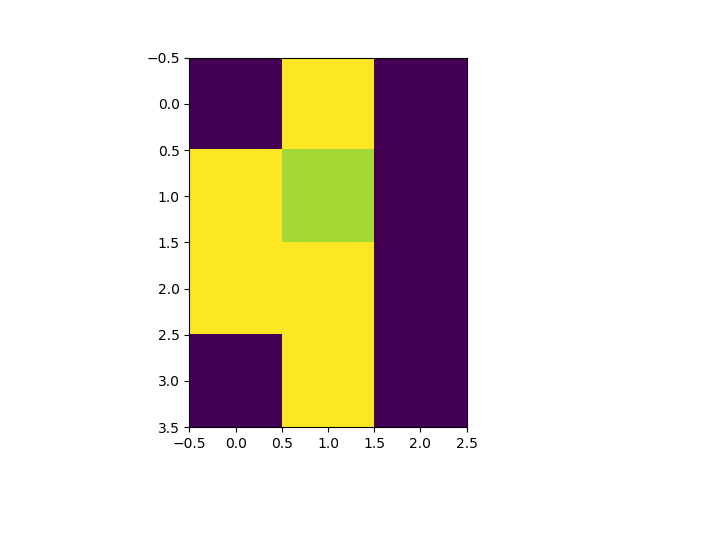

KeyboardInterrupt: 

In [4]:
model = Net(mod = False)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
  

x_fire = np.array(random.sample(range(1,150), 45))
y_fire = x_fire + 2

for e in range(150):
    in_stream = torch.tensor([e in x_fire, e in y_fire], dtype=torch.float)#,e in y_fire], dtype=torch.float)
    #if 1 in in_stream:
    #   print("In signal")
    out,spikes = model(in_stream)
    draw_spikes(spikes, ax, l_dim = 4, n_layers = 3)
    fig.canvas.set_window_title("Step : {},   {}".format(e,in_stream.data))
    fig.canvas.draw()
    time.sleep(0.1)